In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
import scanpy as sc
import anndata
import pandas as pd
import tools
import logging
import mira

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## model setup
atac_model = mira.topics.AccessibilityTopicModel(counts_layer='counts',
                                                 dataset_loader_workers = 3)

rna_model = mira.topics.ExpressionTopicModel(
    # endogenous_key='endog',
    # exogenous_key='exdog',
    counts_layer='counts',
    seed = 0,
    hidden=64, # to make the tutorial faster. In practice, use the default of 128!
)                                                 

In [3]:
## load trained model
rna_model = mira.topics.ExpressionTopicModel.load('MIRA/rna_topic_model.pth')
atac_model = mira.topics.AccessibilityTopicModel.load('MIRA/atac_topic_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [3]:
# rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna_mira.h5ad")
# atac_data =  anndata.read_h5ad("data/datasets/mouse_brain_atac_mira.h5ad")
rna_data = anndata.read_h5ad("data/datasets/mouse_hair_rna_interim.h5ad")
atac_data =  anndata.read_h5ad("data/datasets/mouse_hair_atac_interim.h5ad")

In [5]:
rna_data

AnnData object with n_obs × n_vars = 6436 × 959
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9'
    var: 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_topic_compositions', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
atac_data.layers['counts'] = atac_data.X.copy()


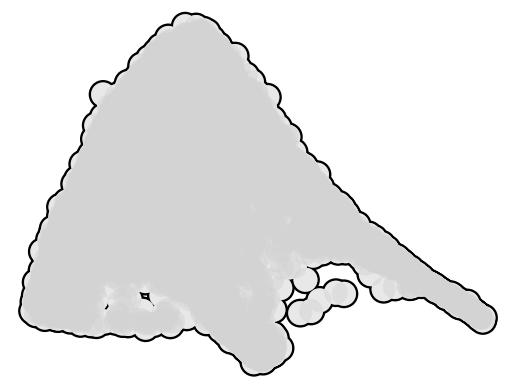

In [12]:
# rna_model.predict(rna_data)
# rna_model.get_umap_features(rna_data, box_cox=0.5)
## if the distance is already calculated
# sc.pp.neighbors(rna_data, use_rep = 'X_umap', metric = 'manhattan')
# sc.tl.umap(rna_data, min_dist=0.1, negative_sample_rate=0.05)
sc.pl.umap(rna_data, frameon=False, size = 1200, alpha = 0.5, add_outline=True,outline_width=(0.1,0))

In [17]:
rna_model.get_learning_rate_bounds(rna_data, eval_every=1, upper_bound_lr=1)

Learning rate range test: 100%|██████████| 598/598 [00:16<00:00, 35.24it/s]
INFO:mira.topic_model.base:Set learning rates to: (4.0261102574226336e-06, 0.1726814836252221)


(4.0261102574226336e-06, 0.1726814836252221)

INFO:mira.topic_model.base:Set learning rates to: (4.066573338209014e-06, 0.2576105020974429)


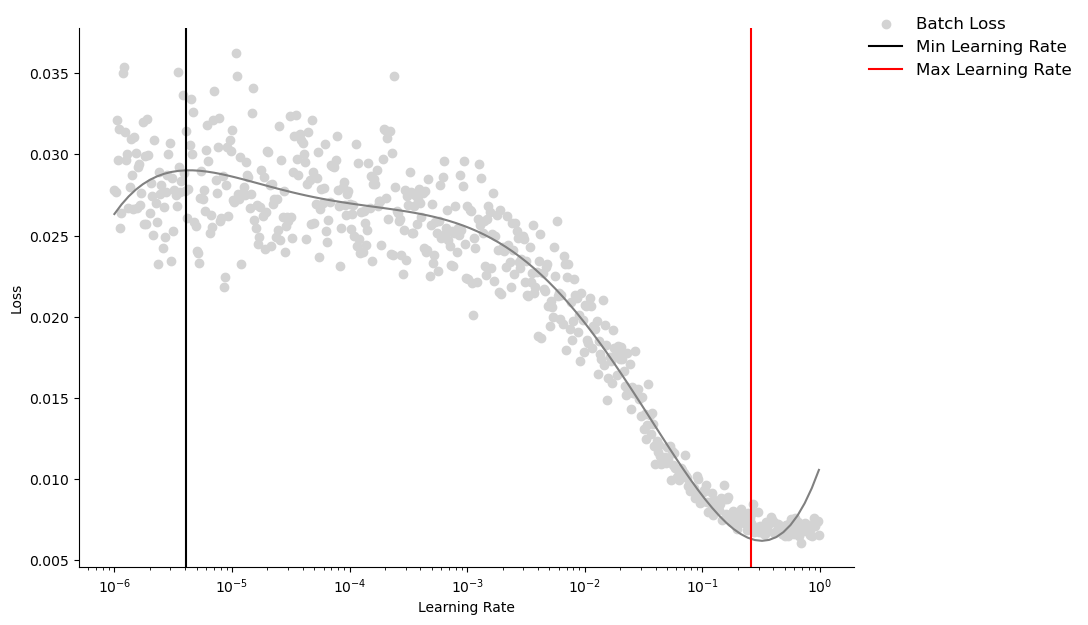

In [18]:
rna_model.trim_learning_rate_bounds(1e-2, 0.1)
_ = rna_model.plot_learning_rate_bounds()

In [19]:
Rtuner = mira.topics.TopicModelTuner(
    rna_model,
    save_name = 'tuning-tutorial',
    seed = 0,
    iters=32, # Recommend 30-64 iterations of tuning.
    max_topics = 15 # to speed up convergence! Leave at default of 55 when working with new data.
)
Rtuner.train_test_split(rna_data)


INFO:mira.adata_interface.topic_model:Added col: test_set
INFO:mira.adata_interface.core:Added cols to obs: test_set


In [20]:
Rtuner.tune(rna_data, n_workers=5)


In [21]:
Rtuner.select_best_model(rna_data, record_umaps=True)


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9090, 'encoder_dropout': 0.1038, 'kl_strategy': 'monotonic', 'num_epochs': 37, 'num_layers': 2, 'num_topics': 14}
Epoch 38 done. Recent losses: 4.276e-01 --> 4.278e-01 --> 4.268e-01 --> 4.277e-01 --> 4.275e-01: 100%|██████████| 37/37 [02:42<00:00,  4.39s/it]
INFO:mira.topic_model.trainer:Score: 4.19020e-01
Predicting latent vars: 100%|██████████| 13/13 [00:01<00:00, 12.20it/s]


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9106, 'encoder_dropout': 0.1283, 'kl_strategy': 'cyclic', 'num_epochs': 34, 'num_layers': 2, 'num_topics': 15}
Epoch 35 done. Recent losses: 4.287e-01 --> 4.282e-01 --> 4.283e-01 --> 4.277e-01 --> 4.282e-01: 100%|██████████| 34/34 [02:30<00:00,  4.44s/it]
INFO:mira.topic_model.trainer:Score: 4.18713e-01
Predicting latent vars: 100%|██████████| 13/13 [00:01<00:00, 10.96it/s]


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9234, 'encoder_dropout': 0.1369, 'kl_strategy': 'monotonic', 'num_epochs': 34, 'num_layers': 2, 'num_topics': 14}
Epoch 35 done. Recent losses: 4.285e-01 --> 4.282e-01 --> 4.283e-01 --> 4.276e-01 --> 4.274e-01: 100%|██████████| 34/34 [02:26<00:00,  4.32s/it]
INFO:mira.topic_model.trainer:Score: 4.18458e-01
Predicting latent vars: 100%|██████████| 13/13 [00:01<00:00, 12.73it/s]


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9229, 'encoder_dropout': 0.1340, 'kl_strategy': 'monotonic', 'num_epochs': 33, 'num_layers': 2, 'num_topics': 14}
Epoch 34 done. Recent losses: 4.288e-01 --> 4.277e-01 --> 4.280e-01 --> 4.278e-01 --> 4.278e-01: 100%|██████████| 33/33 [02:19<00:00,  4.23s/it]
INFO:mira.topic_model.trainer:Score: 4.18340e-01
Predicting latent vars: 100%|██████████| 13/13 [00:01<00:00, 11.53it/s]


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9742, 'encoder_dropout': 0.0125, 'kl_strategy': 'monotonic', 'num_epochs': 36, 'num_layers': 2, 'num_topics': 14}
Epoch 37 done. Recent losses: 4.274e-01 --> 4.270e-01 --> 4.269e-01 --> 4.264e-01 --> 4.264e-01: 100%|██████████| 36/36 [02:30<00:00,  4.19s/it]
INFO:mira.topic_model.trainer:Score: 4.17971e-01
Predicting latent vars: 100%|██████████| 13/13 [00:01<00:00, 11.50it/s]
INFO:mira.topic_model.trainer:Set parameters to best combination: {'batch_size': 32, 'beta': 0.9742, 'encoder_dropout': 0.0125, 'kl_strategy': 'monotonic', 'num_epochs': 36, 'num_layers': 2, 'num_topics': 14}


INFO:mira.topic_model.trainer:Training model with all data.
Epoch 37 done. Recent losses: 4.260e-01 --> 4.255e-01 --> 4.256e-01 --> 4.258e-01 --> 4.254e-01: 100%|██████████| 36/36 [03:18<00:00,  5.50s/it]
INFO:mira.topic_model.base:Moving model to device: cpu


ExpressionTopicModel(
  (decoder): Decoder(
    (beta): Linear(in_features=14, out_features=959, bias=False)
    (bn): BatchNorm1d(959, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): ExpressionEncoder(
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=960, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.012464089098341069, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=30, bias=True)
        (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

In [22]:
#mouse model rna_model.save('MIRA/rna_topic_model.pth')
rna_model.save('MIRA/hair_rna_topic_model.pth')

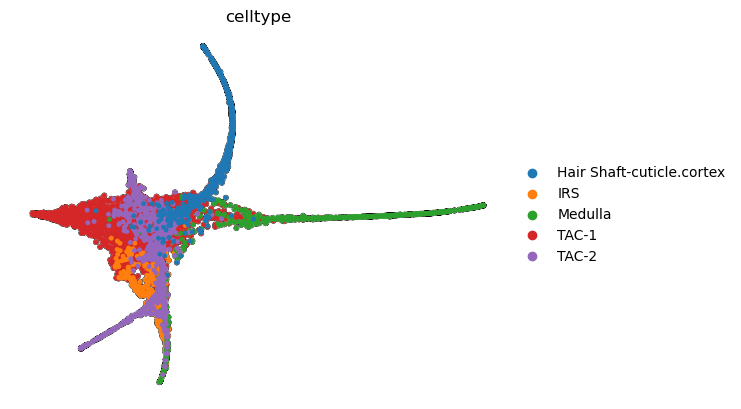

In [25]:
# rna_model.predict(rna_data)
# rna_model.get_umap_features(rna_data, box_cox=0.5)
# sc.pp.neighbors(rna_data, use_rep = 'X_umap_features', metric = 'manhattan')
# sc.tl.umap(rna_data, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(rna_data, frameon=False, size = 20, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['celltype', "latent_time"])

Predicting latent vars: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


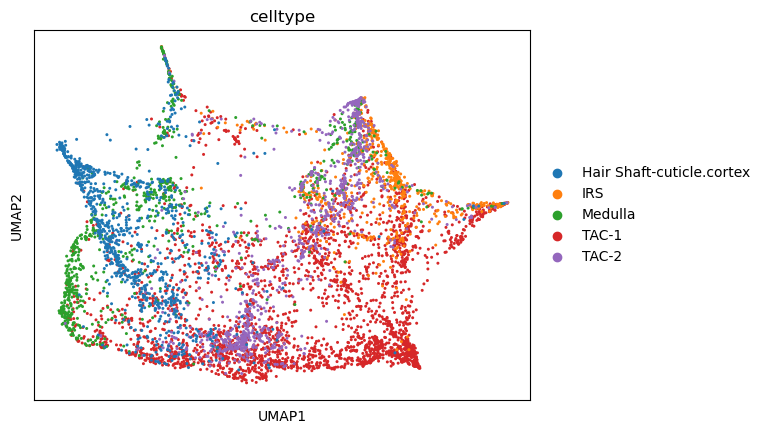

In [11]:
atac_model.predict(atac_data)
atac_model.get_umap_features(atac_data, box_cox=0.5)
sc.pp.neighbors(atac_data, use_rep = 'X_umap_features', metric = 'manhattan')
sc.tl.umap(atac_data, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(atac_data,
          color='celltype')

In [4]:
# atac_data = anndata.read_h5ad("data/datasets/mouse_brain_atac.h5ad")
# atac_data.raw = atac_data
atac_data.layers['counts'] = atac_data.X.copy()


In [5]:
atac_model.get_learning_rate_bounds(atac_data, eval_every=1, upper_bound_lr=5)


Learning rate range test:  95%|█████████▌| 569/598 [00:20<00:00, 31.40it/s]ERROR:mira.topic_model.base:
Gradient overflow from too high learning rate, stopping test early.
INFO:mira.topic_model.base:Set learning rates to: (5.4051509125904634e-06, 0.12915936841233608)


(5.4051509125904634e-06, 0.12915936841233608)

INFO:mira.topic_model.base:Set learning rates to: (5.405204964369845e-06, 0.17434691103234567)
Learning rate range test:  95%|█████████▌| 569/598 [00:20<00:01, 27.27it/s]


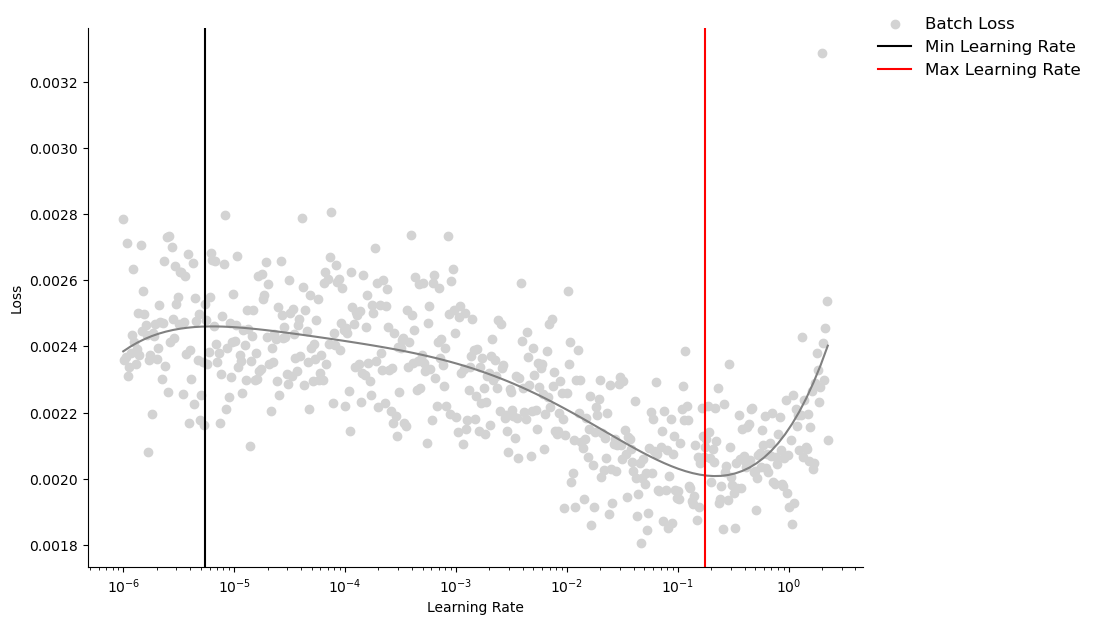

In [6]:
atac_model.trim_learning_rate_bounds(1e-5, 0.2)
_ = atac_model.plot_learning_rate_bounds()

In [7]:
Atuner = mira.topics.TopicModelTuner(
    atac_model,
    save_name = 'ATAC',
    seed = 0,
    iters=20, # Recommend 30-64 iterations of tuning.
    max_topics = 15 # to speed up convergence! Leave at default of 55 when working with new data.
)
Atuner.train_test_split(atac_data)


INFO:mira.adata_interface.topic_model:Added col: test_set
INFO:mira.adata_interface.core:Added cols to obs: test_set


In [8]:
Atuner.tune(atac_data, n_workers=1)


In [9]:
Atuner.select_best_model(atac_data, record_umaps=True)


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 128, 'beta': 0.9190, 'encoder_dropout': 0.0119, 'kl_strategy': 'monotonic', 'num_epochs': 35, 'num_layers': 2, 'num_topics': 15}
Epoch 36 done. Recent losses: 1.284e-01 --> 1.284e-01 --> 1.283e-01 --> 1.283e-01 --> 1.282e-01: 100%|██████████| 35/35 [01:50<00:00,  3.16s/it]
INFO:mira.topic_model.trainer:Score: 1.29830e-01
Predicting latent vars: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 128, 'beta': 0.9024, 'encoder_dropout': 0.0129, 'kl_strategy': 'monotonic', 'num_epochs': 33, 'num_layers': 2, 'num_topics': 15}
Epoch 34 done. Recent losses: 1.283e-01 --> 1.284e-01 --> 1.285e-01 --> 1.283e-01 --> 1.283e-01: 100%|██████████| 33/33 [01:34<00:00,  2.87s/it]
INFO:mira.topic_model.trainer:Score: 1.29815e-01
Predicting latent vars: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 128, 'beta': 0.9027, 'encoder_dropout': 0.0127, 'kl_strategy': 'monotonic', 'num_epochs': 33, 'num_layers': 2, 'num_topics': 15}
Epoch 34 done. Recent losses: 1.285e-01 --> 1.284e-01 --> 1.283e-01 --> 1.282e-01 --> 1.283e-01: 100%|██████████| 33/33 [01:41<00:00,  3.09s/it]
INFO:mira.topic_model.trainer:Score: 1.29808e-01
Predicting latent vars: 100%|██████████| 13/13 [00:11<00:00,  1.08it/s]


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 128, 'beta': 0.9047, 'encoder_dropout': 0.0340, 'kl_strategy': 'monotonic', 'num_epochs': 29, 'num_layers': 2, 'num_topics': 13}
Epoch 30 done. Recent losses: 1.286e-01 --> 1.287e-01 --> 1.285e-01 --> 1.285e-01 --> 1.284e-01: 100%|██████████| 29/29 [01:20<00:00,  2.77s/it]
INFO:mira.topic_model.trainer:Score: 1.29827e-01
Predicting latent vars: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 64, 'beta': 0.9604, 'encoder_dropout': 0.0964, 'kl_strategy': 'cyclic', 'num_epochs': 39, 'num_layers': 2, 'num_topics': 9}
Epoch 40 done. Recent losses: 1.290e-01 --> 1.288e-01 --> 1.288e-01 --> 1.287e-01 --> 1.289e-01: 100%|██████████| 39/39 [01:42<00:00,  2.64s/it]
INFO:mira.topic_model.trainer:Score: 1.29805e-01
Predicting latent vars: 100%|██████████| 13/13 [00:11<00:00,  1.10it/s]
INFO:mira.topic_model.trainer:Set parameters to best combination: {'batch_size': 64, 'beta': 0.9604, 'encoder_dropout': 0.0964, 'kl_strategy': 'cyclic', 'num_epochs': 39, 'num_layers': 2, 'num_topics': 9}
INFO:mira.topic_model.trainer:Training model with all data.


Epoch 40 done. Recent losses: 1.291e-01 --> 1.290e-01 --> 1.289e-01 --> 1.289e-01 --> 1.289e-01: 100%|██████████| 39/39 [02:06<00:00,  3.24s/it]
INFO:mira.topic_model.base:Moving model to device: cpu


AccessibilityTopicModel(
  (decoder): Decoder(
    (beta): Linear(in_features=9, out_features=112656, bias=False)
    (bn): BatchNorm1d(112656, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): DANEncoder(
    (drop): Dropout(p=0.09637075956246595, inplace=False)
    (embedding): Embedding(112657, 128, padding_idx=0)
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=129, out_features=18, bias=True)
        (1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

In [ ]:
torch.cuda.is_available()

In [10]:
atac_model.save('MIRA/hair_atac_topic_model.pth')


In [ ]:
mira.tools.motif_scan.logger.setLevel(logging.INFO) # make sure progress messages are displayed

mira.tl.get_motif_hits_in_peaks(atac_data,
                    genome_fasta='mm10.fa',
                    chrom = 'chr', start = 'start', end = 'end') # indicate chrom, start, end of peaks


In [ ]:
atac_model.get_enriched_TFs(atac_data, topic_num=4, top_quantile=0.1)
atac_model.get_enriched_TFs(atac_data, topic_num=10, top_quantile=0.1)
# atac_model.get_enriched_TFs(atac_data, topic_num=0, top_quantile=0.1)


In [ ]:
atac_model.get_enriched_TFs(atac_data, topic_num=14, top_quantile=0.1)


In [ ]:
factor4 = pd.DataFrame(atac_model.get_enrichments(4))
factor10 = pd.DataFrame(atac_model.get_enrichments(10))
# factor0 = pd.DataFrame(atac_model.get_enrichments(0))
# factor15 = pd.DataFrame(atac_model.get_enrichments(14))


In [ ]:
factor4.sort_values(by=['pval'])

In [ ]:
factor10.sort_values(by=['pval'])


In [36]:
atac_data.write_h5ad("data/datasets/mouse_brain_atac_mira.h5ad")

In [35]:
rna_data.write_h5ad("data/datasets/mouse_brain_rna_mira.h5ad")

In [ ]:
rna_data.var.loc[rna_data.var.exog==True, :]

In [ ]:
## HALO loadings
loadings = np.loadtxt("loading_neural_causal.txt")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
# randindex = np.random.randint(0, 123883, 10000)
plt.figure(figsize=(25,4))
hm = sns.heatmap(loadings)
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks") 

In [ ]:
sns.histplot(data=loadings[7,:], bins=2)

In [ ]:
atac_model._score_features().shape

In [ ]:
miraloading = atac_model._score_features()
plt.figure(figsize=(25,4))
hm = sns.heatmap(miraloading)
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks") 

In [ ]:

atac_model.get_enriched_TFs_outside(atac_data, topic_num=0, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=1, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=2, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=3, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=4, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=5, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=6, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=7, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=8, top_quantile=0.1, loadings=loadings)
atac_model.get_enriched_TFs_outside(atac_data, topic_num=9, top_quantile=0.1, loadings=loadings)


In [ ]:
for i in range(10):
    factor4 = pd.DataFrame(atac_model.get_enrichments(i))
    print(factor4.pval.max())

In [ ]:
factor4 = pd.DataFrame(atac_model.get_enrichments(1))
factor4.sort_values(by=['pval']).head(10)

In [ ]:
factor5 = pd.DataFrame(atac_model.get_enrichments(1))
factor5.sort_values(by=['pval']).head(10)

In [ ]:
factor4.pval.max()

In [ ]:
atac_model.get_enriched_TFs(atac_data, topic_num=0, top_quantile=0.1)
atac_model.get_enriched_TFs(atac_data, topic_num=1, top_quantile=0.1)


atac_model.get_enriched_TFs(atac_data, topic_num=9, top_quantile=0.1)
factor9 = pd.DataFrame(atac_model.get_enrichments(0))
factor9.sort_values(by=['pval'])


In [ ]:
atac_model.plot_compare_topic_enrichments(8, 3,
            fontsize=7, label_closeness=5, figsize=(8,8),
             pval_threshold = (1e-5, 1e-5)
        )

In [ ]:
atac_model.plot_compare_topic_enrichments(9, 8,
            fontsize=7, label_closeness=5, figsize=(8,8),
             pval_threshold = (1e-5, 1e-5)
        )

In [ ]:
atac_model.plot_compare_topic_enrichments(9, 2,
            fontsize=7, label_closeness=3, figsize=(8,8),
             pval_threshold = (1e-5, 1e-5)
        )

In [ ]:
atac_model.plot_compare_topic_enrichments(5, 4,
            fontsize=7, label_closeness=3, figsize=(8,8),
             pval_threshold = (1e-3, 1e-3)
        )

In [ ]:
atac_model.plot_compare_topic_enrichments(3, 6,
            fontsize=7, label_closeness=3, figsize=(8,8),
             pval_threshold = (1e-4, 1e-4)
        )

# Testing the PR model of Mira


In [43]:
## annotate the ATAC data
mira.tl.get_distance_to_TSS(atac_data,
                            tss_data='data/datasets/mm10_tss_data.bed12',
                            genome_file='data/datasets/mm10.chrom.sizes')

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [7]:
# rna_data.var.index = rna_data.var.index.str.upper()
rna_data.var

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog,types
XKR4,ENSMUSG00000051951,Gene Expression,Gene Expression,2283,True,1.876801,2.101737,0.699344,True,False,neither
GM1992,ENSMUSG00000089699,Gene Expression,Gene Expression,443,False,0.124291,0.168296,-0.830691,False,False,decoupled
GM19938,ENSMUSG00000102331,Gene Expression,Gene Expression,683,False,0.228712,0.461415,-0.033439,False,False,coupled
RP1,ENSMUSG00000025900,Gene Expression,Gene Expression,36,True,0.020071,0.943040,1.276528,True,True,neither
MRPL15,ENSMUSG00000033845,Gene Expression,Gene Expression,971,False,0.319294,0.355616,-0.493027,False,False,neither
...,...,...,...,...,...,...,...,...,...,...,...
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,Gene Expression,695,False,0.239101,0.455474,-0.049597,False,False,coupled
VAMP7,ENSMUSG00000051412,Gene Expression,Gene Expression,755,False,0.239121,0.339640,-0.364654,False,False,coupled
TMLHE,ENSMUSG00000079834,Gene Expression,Gene Expression,559,True,0.223619,0.611113,0.373723,True,False,neither
4933409K07RIK,ENSMUSG00000095552,Gene Expression,Gene Expression,52,False,0.012195,-0.123272,-1.623724,False,False,decoupled


In [9]:
rp_args = dict(expr_adata = rna_data, atac_adata= atac_data)
rp_genes = list(rna_model.features[rna_model.highly_variable])

for topic in range(rna_model.num_topics):
    rp_genes.extend(rna_model.get_top_genes(topic, 200))
rp_genes = list(set(rp_genes))


In [10]:
rp_genes = [str(e).upper() for e in rp_genes]
rp_genes

['KIF4',
 'KIF24',
 'TFAP2D',
 'SPARC',
 'CCDC136',
 'GM32916',
 'CELRR',
 'ASF1B',
 'RYR2',
 'TCN2',
 'ELN',
 'KIF20A',
 'GLCCI1',
 'SLF1',
 'LGALS1',
 'RGS20',
 'ID1',
 'DISC1',
 'SEMA5B',
 'CHODL',
 'KHDRBS2',
 'G630016G05RIK',
 'NRN1',
 'MCAM',
 'FLRT2',
 'ATAD2',
 'PCDH7',
 'GM28822',
 'TESK2',
 'HIST1H2AP',
 'CKS2',
 'MEST',
 'PPP1R14C',
 'CTHRC1',
 'SLC39A12',
 'VWC2L',
 'RANBP17',
 'MAP3K1',
 'HS6ST2',
 'NOVA1',
 'IGFBP2',
 'MSN',
 'SLCO1C1',
 'NAV2',
 'MFNG',
 'SPAG5',
 'ABLIM1',
 'UNC5D',
 'BTG2',
 'NEUROD1',
 'P4HA3',
 'TSPAN7',
 'GABRB1',
 'GM27008',
 '4930544I03RIK',
 'RGS5',
 '9130024F11RIK',
 'NOX4',
 'RCAN2',
 'LRRK1',
 'MEG3',
 'RAD51B',
 'CUX1',
 'SNED1',
 'HGF',
 'CRYM',
 'LIX1',
 'COL14A1',
 'PLS1',
 'ADGRG2',
 'APCDD1',
 'NOTCH2',
 'NAALADL2',
 'PROM1',
 'CDR1OS',
 'BCAR3',
 'OLFM3',
 'HMGN2',
 'RFX4',
 'PRRX1',
 'FBXO47',
 'KATNAL2',
 'KCTD8',
 'CDH9',
 'NETO2',
 '9530026P05RIK',
 'GM12296',
 'GM13986',
 'TMEM97',
 'WDHD1',
 'CNTNAP2',
 'GSE1',
 'PIMREG',
 'SAMD4'

In [59]:
pd.DataFrame(atac_data.var)

,chr,start,end,n_cells
peak_id,,,,
1,chr1,3094399,3095523,235
2,chr1,3113503,3114077,103
3,chr1,3119414,3121804,449
4,chr1,3198296,3198611,46
5,chr1,3210204,3210605,52
...,...,...,...,...
123879,GL456216.1,37994,39286,266
123880,GL456216.1,40534,41810,139
123881,GL456216.1,49045,49376,35


In [64]:
atac_data.uns['distance_to_TSS_genes']

['4933401J01RIK',
 'GM26206',
 'GM18956',
 'GM37180',
 'GM37363',
 'GM1992',
 'GM37686',
 'GM37329',
 'GM7341',
 'GM38148',
 'GM19938',
 'XKR4',
 'GM10568',
 'GM38385',
 'GM27396',
 'GM37381',
 'GM6101',
 'GM37483',
 'RP1',
 'SOX17',
 'GM37587',
 'GM7357',
 'GM22307',
 'GM38076',
 'GM37323',
 'GM7369',
 'GM6085',
 'GM6119',
 'GM25493',
 'GM2053',
 'GM6123',
 'GM37144',
 'MRPL15',
 'LYPLA1',
 'GM37988',
 'TCEA1',
 'GM6104',
 'GM37277',
 'GM17100',
 'GM37079',
 'GM16041',
 'RGS20',
 'GM17101',
 'ATP6V1H',
 'GM7182',
 'GM37567',
 'GM38264',
 'OPRK1',
 'GM36965',
 'GM22463',
 'GM37429',
 'NPBWR1',
 'GM19214',
 'RB1CC1',
 '4732440D04RIK',
 'ALKAL1',
 'GM2147',
 'GM7417',
 'GM19026',
 'ST18',
 'GM42492',
 'GM7449',
 'GM37108',
 'GM37275',
 'GM37225',
 'GM37489',
 'GM5694',
 'PCMTD1',
 'GM26983',
 'GM38372',
 'GM9826',
 'NRAS-PS2',
 'GM23274',
 'GM19002',
 'GM26901',
 'GM18984',
 'GM30414',
 'GM37791',
 'GM7470',
 'RPS2-PS2',
 'GM38216',
 'GM38024',
 'GM16284',
 'GM38259',
 'GM23358',
 'GM370

In [22]:
rp_genes.remove("GM5089-1")
rp_genes.remove("PAKAP-1")

In [43]:
litemodel = mira.rp.LITE_Model(expr_model = rna_model,
                              accessibility_model=atac_model,
                              genes = ["GRIN2B"])

In [44]:
!mkdir -p rpmodels/
!mkdir -p rpmodels/mira
litemodel.counts_layer = 'counts'
litemodel.fit(expr_adata=rna_data, atac_adata=atac_data, n_workers=4)

Fitting models: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


In [31]:
!mkdir -p rpmodels/mira/individual

In [32]:
litemodel.save('rpmodels/mira/')


In [26]:
pd.DataFrame(
    litemodel.parameters_
).T

,theta,gamma,bias,bn_mean,bn_var,bn_eps,a_upstream,a_promoter,a_downstream,distance_upstream,distance_downstream
KIF4,0.108442,1.357771,-1.975864,0.021646,0.000011,0.00001,1.122159,0.183531,0.000439,30.397787,2.427931
KIF24,0.420773,0.651135,-1.067186,3.586938,0.161341,0.00001,1.606229,0.594950,0.169268,95.828720,13.093599
TFAP2D,0.081114,1.871408,-1.612064,0.141619,0.002514,0.00001,0.411611,1.360894,0.364900,11.490392,5.595816
SPARC,0.481759,1.354764,-1.895157,1.831337,0.065978,0.00001,0.306470,1.336457,0.470556,5.173132,195.440811
CCDC136,0.721511,0.452664,0.054041,0.039583,0.000052,0.00001,1.125892,0.217214,0.002281,2.892997,13.781065
...,...,...,...,...,...,...,...,...,...,...,...
CP,0.142805,0.383032,-3.010677,0.025063,0.000633,0.00001,0.549597,0.425397,0.545352,11.881635,6.103345
GM26862,0.182951,0.777988,-3.790149,0.026716,0.000513,0.00001,0.664857,0.227338,0.349924,6.915940,2.891397
PAG1,0.786364,1.381065,0.444680,0.005755,0.000002,0.00001,1.574931,0.072877,0.000132,2.190470,6.739680
LIPG,0.251844,0.716398,-2.703596,0.869727,0.008089,0.00001,0.805763,0.574319,0.683083,30.544851,46.014065


In [27]:
litemodel["SLC35F1"].get_influential_local_peaks(atac_data, decay_periods = 5.)

/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/mira/adata_interface/rp_model.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_peaks['distance_to_TSS'] = np.abs(dist)
/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/mira/adata_interface/rp_model.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proximal_peaks['is_upstream'] = dist <= 0


,chr,start,end,n_cells,types,distance_to_TSS,is_upstream
peak_id,,,,,,,
10427,chr10,52689943,52692246,1112,coupled,562.0,False
10428,chr10,52703270,52705622,653,neither,13914.0,False
10429,chr10,52709338,52709709,53,neither,18991.0,False
10430,chr10,52712117,52712836,91,neither,21944.0,False
10431,chr10,52718278,52718564,37,neither,27889.0,False
10432,chr10,52742393,52743756,402,coupled,52542.0,False
10433,chr10,52748208,52748515,35,coupled,57829.0,False
10434,chr10,52758520,52759006,120,neither,68231.0,False
10435,chr10,52780103,52780614,59,neither,89826.0,False


In [40]:
np.mean(rna_data.layers["LITE_logp"][:,7745])

0.0

# Predicting expression from accessibility


In [ ]:
litemodel.predict(**rp_args)

In [34]:
rna_data.layers["LITE_logp"]

<3365x14583 sparse matrix of type '<class 'numpy.float32'>'
	with 336500 stored elements in Compressed Sparse Row format>

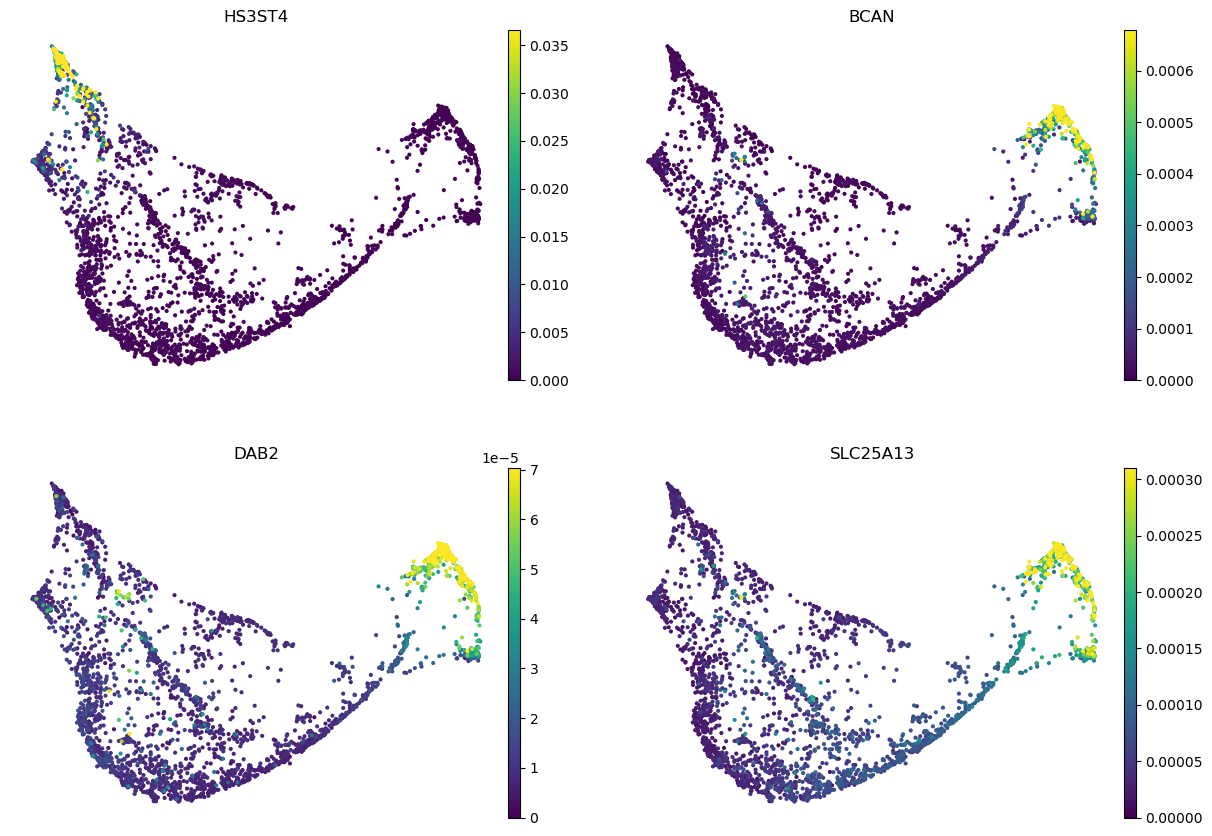

In [25]:
sc.pl.umap(rna_data, color = litemodel.genes[:4], frameon=False, color_map='viridis',
          layer='LITE_prediction', ncols=2, vmin = 0, vmax = 'p97')

In [ ]:
ax = sc.pl.tracksplot(rna_data, {}, groupby='clusters', dendrogram=True)
